# Data Augmentation with ResNet18 

In [10]:
#import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np

#ici ça normalise 

In [11]:
#normalize
import torch
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader
from tqdm import tqdm  # pour la barre de progression

base_dir = "ipeo_hurricane_for_students"

# juste transformer en tensor pour calcul
transform = T.Compose([T.ToTensor()])

train_ds = datasets.ImageFolder(f"{base_dir}/train", transform=transform)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=False, num_workers=4)

mean = 0.
std = 0.
nb_samples = 0

for imgs, _ in tqdm(train_loader, desc="Calcul mean/std"):
    batch_samples = imgs.size(0)
    imgs = imgs.view(batch_samples, imgs.size(1), -1)  # aplatir H*W pour chaque canal
    mean += imgs.mean(2).sum(0)
    std += imgs.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std  /= nb_samples

print("mean:", mean)
print("std:", std)


Calcul mean/std: 100%|██████████| 297/297 [01:44<00:00,  2.83it/s]

mean: tensor([0.3518, 0.3832, 0.2849])
std: tensor([0.1137, 0.0985, 0.0997])


In [12]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
#recuperation mean et std
normalize = T.Normalize(mean, std)
# we invert normalization for plotting later
std_inv = 1 / (std + 1e-7)
unnormalize = T.Normalize(-mean * std_inv, std_inv)

transforms_train = T.Compose([
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    T.RandomGrayscale(p=0.1),
    T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.3),
    T.ToTensor(),
    normalize
])
transforms_val = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    normalize
])
base_dir = "ipeo_hurricane_for_students"
#import datasets with transformations
train_ds = datasets.ImageFolder(os.path.join(base_dir, "train"), transform=transforms_train)
val_ds   = datasets.ImageFolder(os.path.join(base_dir, "validation"), transform=transforms_val)
test_ds  = datasets.ImageFolder(os.path.join(base_dir, "test"), transform=transforms_val)
#change to the begin as in the exercises ??
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


# Now subset stratification

In [13]:
import random
from collections import defaultdict
from torch.utils.data import Subset

def make_stratified_subset(imagefolder_dataset, samples_per_class=10, seed=42):
    random.seed(seed)
    class_indices = defaultdict(list)

    for idx, (_, label) in enumerate(imagefolder_dataset.samples):
        class_indices[label].append(idx)

    selected_indices = []
    for label, indices in class_indices.items():
        k = min(len(indices), samples_per_class)
        selected_indices.extend(random.sample(indices, k))

    return Subset(imagefolder_dataset, selected_indices)

# Create debug dataset 

In [14]:
use_subset = True
samples_per_class = 10

if use_subset:
    train_dataset = make_stratified_subset(train_ds, samples_per_class)
    val_dataset = make_stratified_subset(val_ds, samples_per_class)
else:
    train_dataset = train_ds
    val_dataset = val_ds

# Light Dataloader 

In [15]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0
)
val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,   # IMPORTANT : pas de shuffle en validation
    num_workers=0
)

# print batch

In [16]:
import matplotlib.pyplot as plt

def show_batch(loader, classes, unnormalize):
    images, labels = next(iter(loader))

    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    for img, label, ax in zip(images, labels, axes.flat):
        img = unnormalize(img)
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(classes[label])
        ax.axis("off")

    plt.suptitle("Train batch with data augmentation")
    plt.tight_layout()
    plt.show()


Classes : ['damage', 'no_damage']
Nombre total train : 19000
Nombre utilisé (subset) : 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


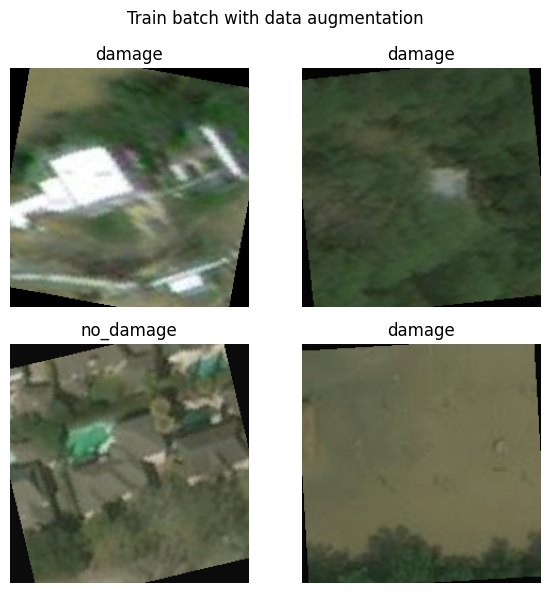

In [17]:
#lastblock 
print("Classes :", train_ds.classes)
print("Nombre total train :", len(train_ds))
print("Nombre utilisé (subset) :", len(train_dataset))

show_batch(train_loader, train_ds.classes, unnormalize)

# time to apply a model

In [18]:
num_classes = len(train_ds.classes)  # = 2
model = resnet18(weights="IMAGENET1K_V1")  # pretrained
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/danichertclement/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 10.8MB/s]


# classic Loss 

In [19]:
import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer for CPU
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4
)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1) c quoi mdr

#  1 epoch fct for training set

In [20]:
def training_step(batch, model, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()

    x, y = batch
    x = x.to(device)
    y = y.to(device)

    y_hat = model(x)
    loss = criterion(y_hat, y)

    loss.backward()
    optimizer.step()

    preds = torch.argmax(y_hat, dim=1)
    accuracy = (preds == y).float().mean().item()

    return loss.item(), accuracy
def train_epoch(train_dl, model, optimizer, criterion, device):
    losses, accuracies = [], []

    for batch in train_dl:
        loss, acc = training_step(batch, model, optimizer, criterion, device)
        losses.append(loss)
        accuracies.append(acc)

    return float(np.mean(losses)), float(np.mean(accuracies))



# validation_epoch

In [21]:
def validate_epoch(val_dl, model, criterion, device):
    model.eval()
    losses, accuracies = [], []

    with torch.no_grad():
        for x, y in val_dl:
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            loss = criterion(y_hat, y)

            preds = torch.argmax(y_hat, dim=1)
            acc = (preds == y).float().mean().item()

            losses.append(loss.item())
            accuracies.append(acc)

    return float(np.mean(losses)), float(np.mean(accuracies))

# loop 

In [22]:
stats = []
num_epochs = 10

for epoch in range(num_epochs):
    trainloss, trainaccuracy = train_epoch(train_loader, model, optimizer, criterion, device)
    valloss, valaccuracy = validate_epoch(val_loader, model, criterion, device)

    print(f"epoch {epoch}; trainloss {trainloss:.4f}, train accuracy {trainaccuracy*100:.2f}% | "
          f"valloss {valloss:.4f}, val accuracy {valaccuracy*100:.2f}%")

    stats.append({
        "epoch": epoch,
        "trainloss": trainloss,
        "trainaccuracy": trainaccuracy,
        "valloss": valloss,
        "valaccuracy": valaccuracy
    })

epoch 0; trainloss 0.7001, train accuracy 60.00% | valloss 0.6959, val accuracy 65.00%
epoch 1; trainloss 0.4387, train accuracy 75.00% | valloss 0.6568, val accuracy 55.00%
epoch 2; trainloss 0.3271, train accuracy 85.00% | valloss 0.5876, val accuracy 60.00%
epoch 3; trainloss 0.3827, train accuracy 90.00% | valloss 0.4789, val accuracy 65.00%
epoch 4; trainloss 0.2631, train accuracy 80.00% | valloss 0.5148, val accuracy 70.00%
epoch 5; trainloss 0.3758, train accuracy 90.00% | valloss 0.5502, val accuracy 70.00%
epoch 6; trainloss 0.1712, train accuracy 90.00% | valloss 0.6364, val accuracy 65.00%
epoch 7; trainloss 0.2662, train accuracy 85.00% | valloss 0.6779, val accuracy 65.00%
epoch 8; trainloss 0.2909, train accuracy 80.00% | valloss 0.4810, val accuracy 70.00%
epoch 9; trainloss 0.0585, train accuracy 100.00% | valloss 0.3757, val accuracy 80.00%


# Visualization

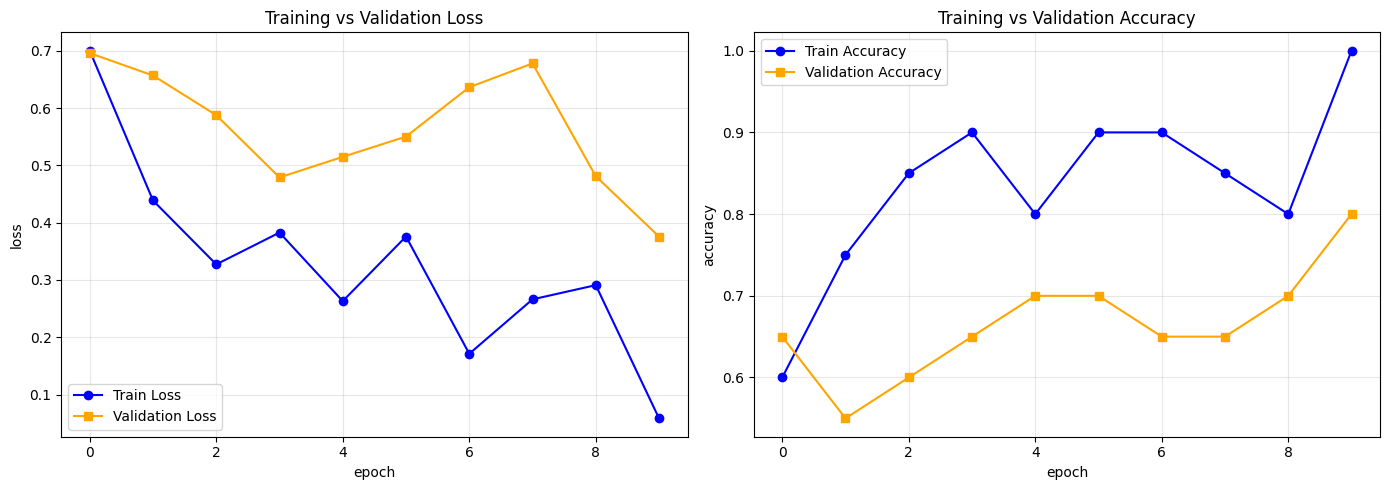

In [23]:
trainlosses = np.array([stat["trainloss"] for stat in stats])
trainaccuracy = np.array([stat["trainaccuracy"] for stat in stats])
vallosses = np.array([stat["valloss"] for stat in stats])
valaccuracy = np.array([stat["valaccuracy"] for stat in stats])
epochs = np.array([stat["epoch"] for stat in stats])

# Créer une figure avec 2 subplots (loss et accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1 : Loss (train + validation)
ax1.plot(epochs, trainlosses, marker='o', label='Train Loss', color='blue')
ax1.plot(epochs, vallosses, marker='s', label='Validation Loss', color='orange')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.set_title("Training vs Validation Loss")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Subplot 2 : Accuracy (train + validation)
ax2.plot(epochs, trainaccuracy, marker='o', label='Train Accuracy', color='blue')
ax2.plot(epochs, valaccuracy, marker='s', label='Validation Accuracy', color='orange')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.set_title("Training vs Validation Accuracy")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()